Corresponding wavelength and bandname of R2260 : WV = 2.25827 ; Band name 192
Red: 1 - (data.band_67 / ((0.333333333333) * data.band_57 + (0.666666666667) * data.band_72))

Green: data.band_233 / data.band_185

Blue: 1 - ((1 - 1 - (data.band_67 / ((0.333333333333) * data.band_57 + (0.666666666667) * data.band_72))) / (1 - 1 - (data.band_81 / ((0.642179772222) * data.band_57 + (0.357820227778) * data.band_124))))


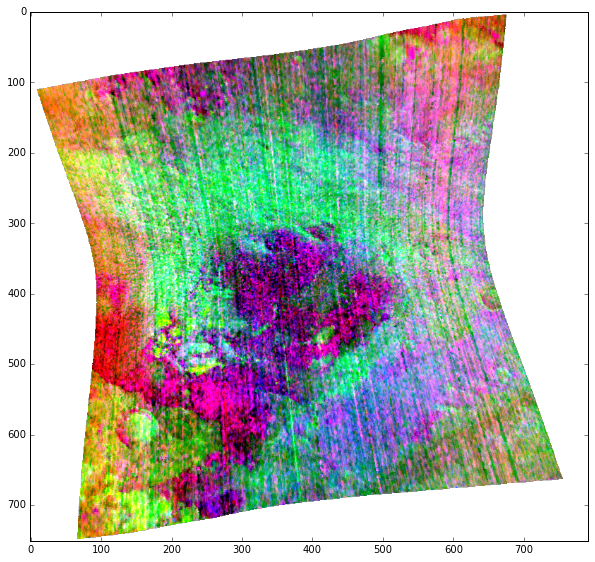

In [1]:
import numpy as np

import re

from astropy.io import fits

%matplotlib inline
import urllib.request
import urllib.parse
import matplotlib.pyplot as plt

# reading the data from the bands_table.fits file

hdulist = fits.open("bands_table.fits")
tabledata = hdulist[1].data # assuming the first extension is a table

cols = hdulist[1].columns

band_name = tabledata["band_name"]
WV = tabledata["wavelength"]

def find_WV_bandname(w):
    # extract wavelength from color name e.g. R295 --> 2950 nanometer --> 2.95 micrometer
    l = float(re.findall("\d+", w)[0])/1000 # converting into micrometer
    
    # nearest wavelength and the corresponding band name index of the given color
    idx = (np.abs(WV-l)).argmin()
    
    # return the corresponding values
    return WV[idx], band_name[idx]

color = "R2260"

print("Corresponding wavelength and bandname of", color ,": WV =", find_WV_bandname(color)[0],
      "; Band name", find_WV_bandname(color)[1])

# Formulation of family $f1$ $$1-\frac{R_c}{a\cdot R_s+b\cdot R_l}$$

# family f1 is of the formuation : 1-(Rc/(a*Rs+b*Rl)

def f1(lst = []):
    # lst has the arguments Rc, Rs, Rl
    WV_c , bn_c = find_WV_bandname(lst[0]) # Rc
    WV_s , bn_s  = find_WV_bandname(lst[1]) # Rs
    WV_l , bn_l  = find_WV_bandname(lst[2]) # Rl

    #print("Band names : {0} = {1}, {2} = {3}, {4} = {5}".format(lst[0], bn_c, lst[1], bn_s, lst[2], bn_l))    
        
    b = (WV_c - WV_s) / (WV_l - WV_s)
    a = 1-b
    
    # WCPS query as given by the computed product
    F = "1 - (data.band_"+str(bn_c)+" / (("+str(a)+") * data.band_"+str(bn_s)+" + ("+str(b)+") * data.band_"+str(bn_l)+"))"
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
        
    return F, FS

# Formulation of family $f2$ $$minimum [1-\frac{R_{1c}}{a\cdot R_{1s}+b\cdot R_{1l}}, 1-\frac{R_{2c}}{a\cdot R_{2s}+b\cdot R_{2l}}]$$

# family f2 is of the formuation : MIN [ 1-(R1c/(a*R1s+b*R1l) , 1-(R2c/(a*R2s+b*R2l) ]

def f2(lst = []):
    # lst has the arguments Rc1, Rs1, Rl1 , Rc2, Rs2, Rl2
    
    F1, FS1 = f1(lst[0:3])
    F2, FS2 = f1(lst[3:])
    
    ####################################################################
    # Comparison not possible as associated band values haven't yet been computed in f1 formulation
    ####################################################################
    
    if (val1>=val2):
        a = a1
        b = b1
        val = val1
        FS = FS1
        print("\nMinimum value is given by the first set of bands")
    else:
        a = a2
        b = b2
        val = val2
        FS = FS2
        print("\nMinimum value is given by the second set of bands")
    
    return a , b, val, FS

# Formulation of family $f3$ $$0.5 \cdot (1-\frac{R_{1c}}{a\cdot R_{1s}+b\cdot R_{1l}}) + 0.5 \cdot (1-\frac{R_{2c}}{a\cdot R_{2s}+b\cdot R_{2l}})$$

# family f3 is of the formuation : 0.5 * (1-(R1c/(a*R1s+b*R1l)) + 0.5*( 1-(R2c/(a*R2s+b*R2l))

def f3(lst = []):
    # lst has the arguments Rc, Rs, Rl
    F1, FS1 = f1(lst[0:3])
    F2, FS2 = f1(lst[3:])
    
    # WCPS query as given by the computed product
    F = "0.5 * ("+F1+")"+" + 0.5 * ("+F2+")" 
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
        
    return F, FS

# Formulation of family $f4$ $$R_1$$

# family f4 is of the formuation : R1

def f4(lst = []):
    # lst has the arguments R1
    
    WV_1 , bn_1 = find_WV_bandname(lst[0]) # R1
    
    # WCPS query as given by the computed product
    F = "data.band_"+str(bn_1)
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
        
    return F, FS

# Formulation of family $f5$ $$\frac{R_1}{R_2}$$

# family f5 is of the formuation : R1/R2

def f5(lst = []):
    # lst has the arguments R1, R2
    
    WV_1 , bn_1 = find_WV_bandname(lst[0]) # R1
    WV_2 , bn_2 = find_WV_bandname(lst[1]) # R1
    
    # WCPS query as given by the computed product
    F = "data.band_"+str(bn_1)+" / data.band_"+str(bn_2)
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
        
    return F, FS

# Formulation of family $f6$ $$1-(\frac{R_1}{R_2 \cdot \frac{R_3}{R_4}})$$

# family f6 is of the formuation : 1-(R1/(R2*(R3/R4)))

def f6(lst = []):
    # lst has the arguments R1, R2, R3, R4
    
    WV_1 , bn_1 = find_WV_bandname(lst[0]) # R1
    WV_2 , bn_2  = find_WV_bandname(lst[1]) # R2
    WV_3 , bn_3  = find_WV_bandname(lst[2]) # R3
    WV_4 , bn_4  = find_WV_bandname(lst[3]) # R3

    # WCPS query as given by the computed product
    F = "1 - (data.band_"+str(bn_1)+" / (data.band_"+str(bn_2)+" * (data.band_"+str(bn_3)+" / data.band_"+str(bn_4)+")))"
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
        
    return F, FS

# Formulation of family $f7$ $$1-\frac{a\cdot R_s+b\cdot R_l}{R_c}$$

# family f7 is of the formuation : 1-((a*Rs+b*Rl)/Rc)

def f7(lst = []):
    # lst has the arguments Rs, Rl, Rc

    WV_s , bn_s  = find_WV_bandname(lst[0]) # Rs
    WV_l , bn_l  = find_WV_bandname(lst[1]) # Rl
    WV_c , bn_c = find_WV_bandname(lst[2]) # Rc

    #print("Band names : {0} = {1}, {2} = {3}, {4} = {5}".format(lst[2], bn_c, lst[0], bn_s, lst[1], bn_l))    
        
    b = (WV_c - WV_s) / (WV_l - WV_s)
    a = 1-b
    
    # WCPS query as given by the computed product
    F = "1 - ( (("+str(a)+") * data.band_"+str(bn_s)+" + ("+str(b)+") * data.band_"+str(bn_l)+") / data.band_"+str(bn_c)+")"
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
        
    return F, FS

# Formulation of family $f8$ $$1-(\frac{1-BD_1}{1-BD_2})$$

# family f8 is of the formuation : 1-((1-BD1)/(1-BD2)) i.e. composed of f1

def f8(lst = []):
    # lst has the arguments dictionary, BD1, BD2
    
    dictionary = lst[0] 
    F1, FS1 = dictionary[lst[1]][0](dictionary[lst[1]][1])
    F2, FS2 = dictionary[lst[2]][0](dictionary[lst[2]][1])
    
    # WCPS query as given by the computed product
    F = "1 - ((1 - "+F1+") / (1 - "+F2+"))"
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
    
    return F, FS

def URL_creator(coverage_id, red, green, blue, products):
    # Takes the coverage_id, the bands in red, green and blue and computes their corresponding
    # products by looking up from the passed dictionary "products"
    
    # storing FS for each channel with corresponding family function in FS1, FS2, FS3 resp.
    F1, FS1 = products[red][0](products[red][1])
    F2, FS2 = products[green][0](products[green][1])
    F3, FS3 = products[blue][0](products[blue][1])
    
    print("Red: "+F1)
    print("\nGreen: "+F2)
    print("\nBlue: "+F3)
    
    URL = "http://access.planetserver.eu:8090/python?wcpsQuery=http://access.planetserver.eu:8080/rasdaman/ows?service=WCS&version=2.0.1&request=ProcessCoverages&query=for data in ( "+coverage_id+" ) return encode({ red: "+FS1+";green: "+FS2+";blue: "+FS3+";alpha: (float)((data.band_100 > 0) * 255)}, \"tiff\", \"nodata=65535\")"
        
    # encoding the URL (not all of it, only from "for in data")
    index = URL.find("for")
    string_to_encode = URL[index:]
    s = urllib.parse.quote(string_to_encode)
    
    encoded_URL = URL[:index]+s
    
    f = urllib.request.urlopen(encoded_URL)
    plt.figure(figsize=(10,10))
    # read the image file in a numpy array
    image = plt.imread(f)
    plt.imshow(image)
        
    # return URL, encoded_URL

summary_products = { "BD1300" : [f1, ["R1320", "R1080", "R1750"]], "BD1400" : [f1, ["R1395", "R1330", "R1467"]], 
                    "BD1435" : [f1, ["R1435", "R1370", "R1470"]], "BD1500_2" : [f1, ["R1525", "R1367", "R1808"]], 
                    "BD1750_2" : [f1, ["R1750", "R1690", "R1815"]], "BD2100_2" : [f1, ["R2132", "R1930", "R2250"]], 
                    "BD2165" : [f1, ["R2165", "R2120", "R2230"]], "BD2190" : [f1, ["R2185", "R2120", "R2250"]],
                    "BD2210_2" : [f1, ["R2210", "R2165", "R2250"]], "BD2230" : [f1, ["R2235", "R2210", "R2252"]],
                    "BD2250" : [f1, ["R2245", "R2120", "R2340"]], "BD2265" : [f1, ["R2265", "R2210", "R2340"]],
                    "BD2290" : [f1, ["R2290", "R2250", "R2350"]], "BD2355" : [f1, ["R2355", "R2300", "R2450"]],
                    "BD2500_2" : [f1, ["R2480", "R2364", "R2570"]], "BD3100" : [f1, ["R3120", "R3000", "R3250"]],
                    "BD3200" : [f1, ["R3320", "R3250", "R3390"]], "BD3400_2" : [f1, ["R3420", "R3250", "R3630"]],
                    "BD2600" : [f1, ["R2600", "R2530", "R2630"]], 
                    "MIN2200" : [f2, ["R2165", "R2120", "R2350", "R2210", "R2120", "R2350"]], 
                    "MIN2250" : [f2, ["R2210", "R2165", "R2350", "R2265", "R2165", "R2350"]], 
                    "MIN2295_2480" : [f2, ["R2295", "R2165", "R2364", "R2480", "R2364", "R2570"]], 
                    "MIN2345_2537" : [f2, ["R2345", "R2250", "R2430", "R2537", "R2430", "R2602"]], 
                    "BD1900_2" : [f3, ["R1930", "R1850", "R2067", "R1985", "R1850", "R2067"]], 
                    "R1330" : [f4,["R1330"]], "R1080" : [f4,["R1080"]],  "R1506" : [f4,["R1506"]],
                    "R2529" : [f4,["R2529"]], "R3920" : [f4,["R3920"]],
                    "IRR2" : [f5,["R2530", "R2210"]], "IRR3" : [f5,["R3500", "R3390"]],
                    "BD3000" : [f6,["R3000", "R2530", "R2530", "R2210"]], 
                    "SINDEX2" : [f7, ["R2120", "R2400", "R2290"]], "CINDEX2" : [f7, ["R3450", "R3875", "R3610"]],} 
                    
summary_products["ICERI_2"] = [f8, [summary_products, "BD1435", "BD1500_2"]]

r = "BD1435"
g = "IRR2"
b = "ICERI_2"

URL_creator("frt000064d9_07_if166l_trr3", r, g, b, summary_products)